# USMA CDX Network (NSA capture)
Network capture made by the NSA for the United States Military Academy Cyber Defense training center.

In [1]:
import hashlib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pprint
import re

from collections import Counter
from dateutil.parser import parse
from datetime import timedelta
from functools import reduce
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from math import floor, sqrt
from matplotlib import pyplot
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

matplotlib.style.use('seaborn-colorblind')

Using TensorFlow backend.


In [2]:
N_SIDS = 100 # number of different SIDs to consider (by importance)
N_EPOCH = 10000 # number of epochs in the LSTM training
N_NEURONS = 50 # number of LSTM cells in the input layer

## Data lookup
Data is in a format with **truncated lines and inverted features** compared to raw snort fast alerts.

### Raw data

In [3]:
raw_data_list = []

with open('../datasets/data_capture_from_NSA', 'r') as raw_data:
    for line in raw_data:
        raw_data_list.append(line.rstrip())

In [4]:
pprint.pprint(raw_data_list[:5])

['[**] [129:4:1] TCP Timestamp is outside of PAWS window [**]',
 '[Priority: 3]',
 '11/08-09:43:09.173299 10.1.60.203:57764 -> 7.204.241.161:25',
 'TCP TTL:63 TOS:0x0 ID:51372 IpLen:20 DgmLen:40 DF',
 '*****R** Seq: 0x787AFC70  Ack: 0x0  Win: 0x0  TcpLen: 20']


## Data cleaning
Data is reformated to **true snort fast alerts**.

In [5]:
tmp_data_list = []
tmp_line = ''

for line in raw_data_list:
    if line != '':
        tmp_line += ' ' + line
    else:
        tmp_data_list.append(tmp_line[1:-1])
        tmp_line = ''

In [6]:
pprint.pprint(tmp_data_list[0])

('[**] [129:4:1] TCP Timestamp is outside of PAWS window [**] [Priority: 3] '
 '11/08-09:43:09.173299 10.1.60.203:57764 -> 7.204.241.161:25 TCP TTL:63 '
 'TOS:0x0 ID:51372 IpLen:20 DgmLen:40 DF *****R** Seq: 0x787AFC70  Ack: 0x0  '
 'Win: 0x0  TcpLen: 2')


In [7]:
cleaned_data_list = []

tmp_pattern = re.compile(r"(.*) (\d{2}/\d{2}\-\d{2}:\d{2}:\d{2}\.\d{6}) (.*)")
for line in tmp_data_list:
    tmp = tmp_pattern.match(line)
    if tmp:
        cleaned_data_list.append(tmp.group(2) + ' ' + tmp.group(1) + ' ' + tmp.group(3))

In [8]:
pprint.pprint(cleaned_data_list[0])

('11/08-09:43:09.173299 [**] [129:4:1] TCP Timestamp is outside of PAWS window '
 '[**] [Priority: 3] 10.1.60.203:57764 -> 7.204.241.161:25 TCP TTL:63 TOS:0x0 '
 'ID:51372 IpLen:20 DgmLen:40 DF *****R** Seq: 0x787AFC70  Ack: 0x0  Win: 0x0  '
 'TcpLen: 2')


## Data preparation
The purpose of this part is to format features and look at data repartition among features of the alerts.

In [9]:
snort_list = []

# date, generator id (gid), snort id (sid), revision number (rev), description, classification, priority, source ip, source port, destination ip, destination port
snort_pattern = re.compile(r"(?P<date>\d{2}/\d{2}\-\d{2}:\d{2}:\d{2}\.\d{6}) \[\*\*\] \[(?P<gid>\d+):(?P<sid>\d+):(?P<rev>\d+)\] (?P<description>.*?) \[\*\*\]\ (?:\[Classification: (?P<classification>.*?)\] )?\[Priority: (?P<priority>\d+)\] (?P<ipsrc>(?:\d+\.){3}\d+)(?::(?P<psrc>\d+))? -> (?P<ipdst>(?:\d+\.){3}\d+)(?::(?P<pdst>\d+))? .*")
for line in cleaned_data_list:
    matched_line = snort_pattern.match(line)
    if matched_line:
        snort_list.append([parse(matched_line.group('date')), matched_line.group('gid'), matched_line.group('sid'), matched_line.group('rev'), matched_line.group('description'), matched_line.group('classification'), matched_line.group('priority'), matched_line.group('ipsrc'), matched_line.group('psrc'), matched_line.group('ipdst'), matched_line.group('pdst')])

columns = ['Date', 'GID', 'SID', 'Rev', 'Description', 'Classification', 'Priority', 'IPsrc', 'Psrc', 'IPdst', 'Pdst']     
snort_df = pd.DataFrame(snort_list, columns=columns).sort_values(by='Date')

In [10]:
snort_df.head()

,Date,GID,SID,Rev,Description,Classification,Priority,IPsrc,Psrc,IPdst,Pdst
0,2019-11-08 09:43:09.173299,129,4,1,TCP Timestamp is outside of PAWS window,None,3,10.1.60.203,57764,7.204.241.161,25
1,2019-11-08 09:45:54.394828,129,4,1,TCP Timestamp is outside of PAWS window,None,3,7.204.241.161,25,10.1.60.203,50176
2,2019-11-08 09:45:54.395078,129,4,1,TCP Timestamp is outside of PAWS window,None,3,7.204.241.161,25,10.1.60.203,50176
3,2019-11-08 09:47:02.322926,129,4,1,TCP Timestamp is outside of PAWS window,None,3,154.241.88.201,80,3.75.190.181,60708
4,2019-11-08 09:47:02.323457,129,4,1,TCP Timestamp is outside of PAWS window,None,3,154.241.88.201,80,3.75.190.181,60708


In [11]:
snort_df.describe()

,Date,GID,SID,Rev,Description,Classification,Priority,IPsrc,Psrc,IPdst,Pdst
count,25741,25741,25741,25741,25741,18602,25741,25741,23299,25741,23299
unique,20692,6,644,21,656,13,3,348,10445,30,843
top,2019-11-10 10:49:19.965754,1,2002677,4,ET SCAN Nikto Web App Scan in Progress,Web Application Attack,1,10.2.197.245,8014,154.241.88.201,80
freq,5,18602,6029,8100,6029,8550,11076,6282,482,20584,19734
first,2019-11-08 09:43:09.173299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2019-11-12 05:32:05.096474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data modeling

In [12]:
frequency = 'D'
grouper = pd.Grouper(key='Date', freq=frequency)
grouped_snort_df = snort_df[['Date', 'SID']].groupby([grouper, 'SID'])['SID'].count().unstack(level=1).fillna(0)
    
if grouped_snort_df.shape[0] < 100:
    frequency = 'H'
    grouper = pd.Grouper(key='Date', freq=frequency)
    grouped_snort_df = snort_df[['Date', 'SID']].groupby([grouper, 'SID'])['SID'].count().unstack(level=1).fillna(0)

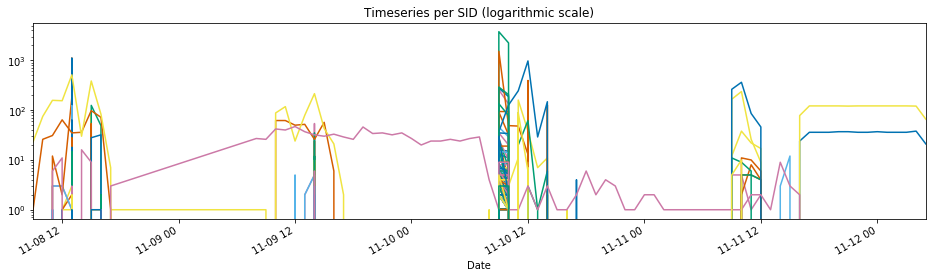

In [13]:
fig, ax = plt.subplots(figsize=(16,4))
grouped_snort_df.plot(ax=ax, legend=False)
plt.title('Timeseries per SID (logarithmic scale)')
ax.set_yscale('log')
plt.show()

### Modeling the top alerts
Here we're modeling timeseries for the most frequent alerts in the dataset (defined by `N_SIDS`) to reduce compute time (more is better).

In [14]:
top_sids = pd.DataFrame(sorted(Counter(snort_df['SID']).items(), key=lambda x:x[1]), columns=['SID', '#']).nlargest(N_SIDS,'#')['SID'].tolist()
top_snort_df = snort_df[snort_df['SID'].isin(top_sids)][['Date', 'SID']].groupby([grouper, 'SID'])['SID'].count().unstack(level=1).fillna(0)

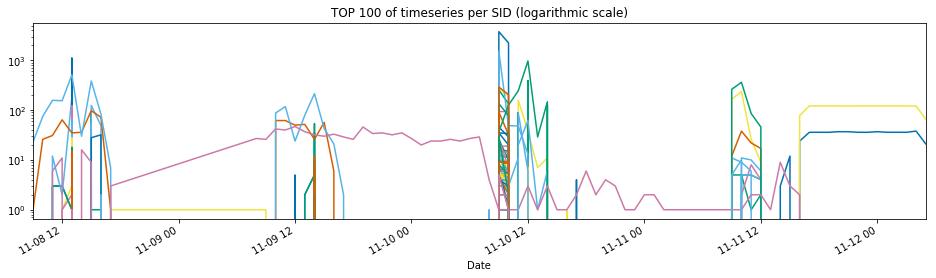

In [15]:
fig, ax = plt.subplots(figsize=(16,4))
top_snort_df.plot(ax=ax, legend=False)
plt.title('TOP ' + str(N_SIDS) + ' of timeseries per SID (logarithmic scale)')
ax.set_yscale('log')
plt.show()

In [16]:
train_snort_df, test_snort_df = np.split(top_snort_df, [int(0.5 * top_snort_df.shape[0]) + 1])

## Prediction
Alert flows are modeled as aggregated signals per SID predicted by a LSTM neural network.

### LSTM

#### Time Series to Supervised Learning

In [17]:
def series_to_supervised(data, sids, n_in=1, n_out=1, dropnan=True):
    """
    Builds a couple of vectors (X,y) with X: input, y: expected output.
    :param data: X
    :param sids: list of SIDs to include
    :param n_in: input offset
    :param n_out: output offset
    :param dropnan: drop incomplete data
    :return: couple of vectors (X,y) with X: input, y: expected output
    """
    prefix = sids + sids
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(prefix[j+1] + '(t-%d)' % i) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(prefix[j+1] + '(t)') for j in range(n_vars)]
        else:
            names += [(prefix[j+1] + '(t+%d)' % i) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### Time Series to Scale

In [18]:
 def scale(values):
    """
    Scales values between 0 and 1 for the activation function.
    :param values: values to scale
    :return: scaled values between 0 and 1
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    
    return scaler, scaled

#### LSTM model

In [19]:
def fit_lstm(train_X, train_y, nb_epoch, neurons=10):
    """
    Trains an LSTM network on training data.
    :param train_X: training data
    :param train_y: training data
    :param nb_epoch: nb_epoch for the LSTM function
    :param neurons: neurons for the LSTM function
    :return: learned LSTM model
    """
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(train_X.shape[2]))
    model.compile(loss='mae', optimizer='adam')
    
    history = model.fit(train_X, train_y, epochs=nb_epoch, batch_size=72, validation_data=(train_X, train_y), verbose=0, shuffle=False)
    
    return history, model

#### Prediction

In [20]:
scaler, scaled = scale(top_snort_df)
reframed = series_to_supervised(scaled, top_sids, 1, 1)
reframed.head()

,7(t-1),4(t-1),2003099(t-1),1394(t-1),2189(t-1),2007757(t-1),8(t-1),3(t-1),12592(t-1),7070(t-1),...,1043(t),1145(t),988(t),1172(t),962(t),1165(t),2008596(t),1852(t),2129(t),2002677(t)
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2
5,0.0,0.041667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
values = reframed.values
train, test = np.split(values, [int(0.5 * values.shape[0]) + 1])
train_X, train_y = train[:, :-N_SIDS], train[:, -N_SIDS:]
test_X, test_y = test[:, :-N_SIDS], test[:, -N_SIDS:]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((40, 1, 100), (40, 100), (38, 1, 100), (38, 100))

In [22]:
history, lstm_model = fit_lstm(train_X, train_y, N_EPOCH, N_NEURONS)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


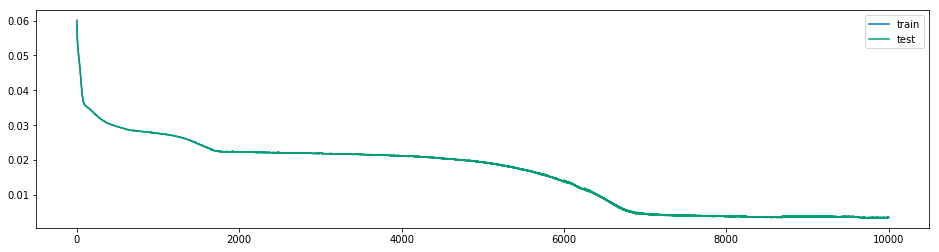

In [23]:
pyplot.figure(figsize=(16,4))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [24]:
yhat = lstm_model.predict(test_X)

In [25]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

In [26]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('RMSE test: %.3f' % rmse)

RMSE test: 124.247


In [27]:
y_hat_df = pd.DataFrame(inv_yhat, columns=top_sids).set_index(test_snort_df.index[-inv_yhat.shape[0]:])
y_df = pd.DataFrame(inv_y, columns=top_sids).set_index(test_snort_df.index[-inv_yhat.shape[0]:])

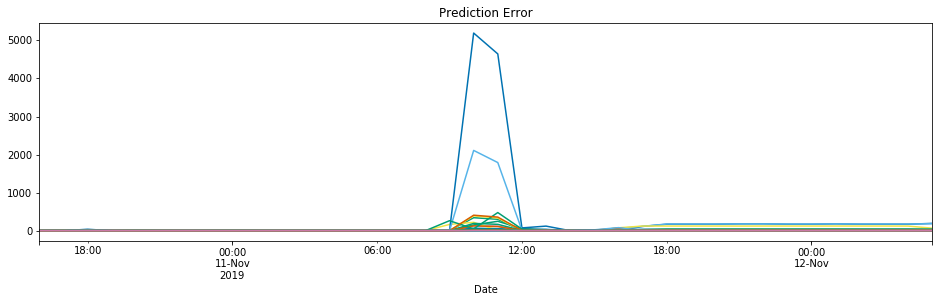

In [28]:
y_df.subtract(y_hat_df).abs().plot(figsize=(16,4), legend=False, title="Prediction Error")
plt.show()

#### Anomaly detection

In [29]:
def detect_anomalies(test, predictions, frequency):
    """
    Detects anomalies on a test signal.
    :param test: data to predict
    :param predictions: prediction on test
    :param frequency: size of the minimal time window
    :return: anomaly windows
    """
    anomalies = {}
    errors = test.subtract(predictions)
    threshold = errors.mean() + 3 * errors.std()
    min_window_size = timedelta(hours=1) if frequency == 'H' else timedelta(days=1)
    
    for sid in errors:
        for idx in errors.index:
            if ((not sid in anomalies) or (sid in anomalies and (anomalies[sid][-1][1] < idx))) and (errors[sid].loc[idx] > threshold[sid]):
                e = idx + min_window_size
                for idx2 in [x for x in errors.index if x > idx]:
                    if np.absolute(errors[sid].loc[idx2]) > threshold[sid]:
                        e = idx2
                    else:
                        break
                anomalies.setdefault(sid, []).append([idx,e])
        
        
    return anomalies

def plot_anomalies(test, anomalies):
    """
    Displays anomaly windows on the test signal.
    :param test: data to analyze
    :param anomalies: anomaly windows by SID
    """
    fig = plt.figure()
    fig.set_size_inches(16, 4)
    
    plt.title("Anomaly detection on NIDS alerts")
    plt.plot(test)
    
    for key, value in anomalies.items():
        for anomaly in value:
            plt.axvspan(anomaly[0], anomaly[1], color='red', alpha=0.1)
        
    plt.show()

In [30]:
anomalies = detect_anomalies(y_df, y_hat_df, frequency)

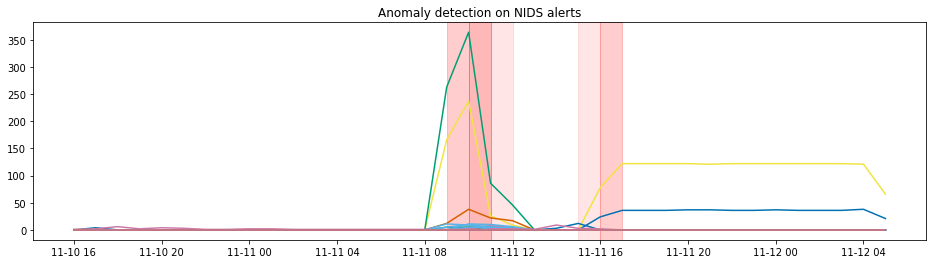

In [31]:
plot_anomalies(y_df, anomalies)

## Meta-alerting on anomalies
The purpose of this part is to be able to forge meta-alerts with the knowledge brought by anomaly detection.

In [32]:
def join_dfs(ldf, rdf):
    """
    Joins two dataframes.
    :param ldf: dataframe 1
    :param rdf: dataframe 2
    :return: joined dataframe
    """
    return ldf.join(rdf, how='inner')

def agg_meta_alerts(alerts_on_anomalies, anomalies):
    """
    Aggregates alerts according to the context defined by anomalies.
    :param alerts_on_anomalies: NIDS alerts in anomaly windows
    :param anomalies: anomaly windows by SID
    :return: meta-alerts in anomaly windows
    """
    alert_dfs = []

    for key, value in anomalies.items():
        for anomaly in value:
            tmp_df = alerts_on_anomalies[(alerts_on_anomalies['Date'] > anomaly[0]) & (alerts_on_anomalies['Date'] < anomaly[1])]
            true_alerts = tmp_df.drop(columns=['GID', 'SID', 'Rev', 'Classification']).drop_duplicates()
            if not true_alerts.empty: 
                meta_alerts = true_alerts.groupby(['Description', 'Priority'])
                date = pd.DataFrame(meta_alerts['Date'].apply(set))
                ip_src = pd.DataFrame(meta_alerts['IPsrc'].apply(set))
                p_src = pd.DataFrame(meta_alerts['Psrc'].apply(set))
                ip_dst = pd.DataFrame(meta_alerts['IPdst'].apply(set))
                p_dst = pd.DataFrame(meta_alerts['Pdst'].apply(set))
                alert_dfs.append(reduce(join_dfs, [date, ip_src, p_src, ip_dst, p_dst]))
    alert_df = pd.concat(alert_dfs)
    
    alert_df['Date'] = alert_df['Date'].astype(str)
    alert_df['IPsrc'] = alert_df['IPsrc'].astype(str)
    alert_df['Psrc'] = alert_df['Psrc'].astype(str)
    alert_df['IPdst'] = alert_df['IPdst'].astype(str)
    alert_df['Pdst'] = alert_df['Pdst'].astype(str)
    
    return alert_df.drop_duplicates()

In [33]:
meta_alerts = agg_meta_alerts(snort_df, anomalies).sort_index()

In [34]:
meta_alerts.head()

Date  \
Description                                        Priority                                                      
(http_inspect) ANOMALOUS HTTP SERVER ON UNDEFIN... 3         {Timestamp('2019-11-11 16:30:00.314702'), Time...   
(http_inspect) DOUBLE DECODING ATTACK              3         {Timestamp('2019-11-11 10:36:35.335335'), Time...   
                                                   3         {Timestamp('2019-11-11 11:38:37.156365'), Time...   
(http_inspect) IIS UNICODE CODEPOINT ENCODING      3         {Timestamp('2019-11-11 09:38:53.339823'), Time...   
                                                   3         {Timestamp('2019-11-11 10:13:36.478784'), Time...   

                                                                                                         IPsrc  \
Description                                        Priority                                                      
(http_inspect) ANOMALOUS HTTP SERVER ON UNDEFIN... 3                                         {'134.240.18.13'}   
(http_inspect) DOUBLE DECODING ATTACK              3         {'10.2.27.91', '10.2.25.117', '10.2.29.248', '...   
                                                   3         {'10.2.29.96', '10.2.29.17', '10.2.25.24', '10...   
(http_inspect) IIS UNICODE CODEPOINT ENCODING      3         {'10.2.23.213', '10.2.23.107', '10.2.23.70', '...   
                                                   3         {'10.2.23.193', '10.2.23.116', '10.2.23.204', ...   

                                                                                                          Psrc  \
Description                                        Priority                                                      
(http_inspect) ANOMALOUS HTTP SERVER ON UNDEFIN... 3                                                  {'8014'}   
(http_inspect) DOUBLE DECODING ATTACK              3             {'33431', '59729', '54084', '56448', '44494'}   
                                                   3             {'39164', '38626', '38610', '43152', '45328'}   
(http_inspect) IIS UNICODE CODEPOINT ENCODING      3         {'52010', '46984', '47002', '60604', '47012', ...   
                                                   3         {'34799', '43582', '37390', '49093', '43580', ...   

                                                                                           IPdst  \
Description                                        Priority                                        
(http_inspect) ANOMALOUS HTTP SERVER ON UNDEFIN... 3         {'134.240.12.92', '134.240.12.190'}   
(http_inspect) DOUBLE DECODING ATTACK              3                          {'154.241.88.201'}   
                                                   3                          {'154.241.88.201'}   
(http_inspect) IIS UNICODE CODEPOINT ENCODING      3                          {'154.241.88.201'}   
                                                   3                          {'154.241.88.201'}   

                                                                                                          Pdst  
Description                                        Priority                                                     
(http_inspect) ANOMALOUS HTTP SERVER ON UNDEFIN... 3         {'1870', '1873', '1827', '1868', '1851', '1855...  
(http_inspect) DOUBLE DECODING ATTACK              3                                                    {'80'}  
                                                   3                                                    {'80'}  
(http_inspect) IIS UNICODE CODEPOINT ENCODING      3                                                    {'80'}  
                                                   3                                                    {'80'}

In [35]:
print('Number of alerts without AI:', str(floor(snort_df.shape[0]/2)))
print('Number of alerts with AI:', str(meta_alerts.shape[0]))
print('\nCompression ratio:', str(100 - meta_alerts.shape[0]/(floor(snort_df.shape[0]/2))*100) + '%')

Number of alerts without AI: 12870
Number of alerts with AI: 31

Compression ratio: 99.75912975912976%


In [36]:
import ast

IPsrc_all = [ast.literal_eval(x) for x in meta_alerts.IPsrc.values]
IPdst_all = [ast.literal_eval(x) for x in meta_alerts.IPdst.values]

Psrc_all = [ast.literal_eval(x) for x in meta_alerts.Psrc.values]
Pdst_all = [ast.literal_eval(x) for x in meta_alerts.Pdst.values]

In [37]:
from functools import reduce

IPsrc_set = reduce(lambda x,y: x.union(y), IPsrc_all)
IPdst_set = reduce(lambda x,y: x.union(y), IPdst_all)

n_spotted_machines = len(IPsrc_set.union(IPdst_set))

print(str(n_spotted_machines), "spotted machines")

Psrc_set = reduce(lambda x,y: x.union(y), Psrc_all)
Pdst_set = reduce(lambda x,y: x.union(y), Pdst_all)

n_spotted_ports = len(Psrc_set.union(Pdst_set))

print(str(n_spotted_ports), "spotted ports")

262 spotted machines
1251 spotted ports


In [38]:
from collections import Counter

flatten = lambda l: [item for sublist in l for item in sublist]

IPsrc_list = flatten(list(x) for x in IPsrc_all)
IPdst_list = flatten(list(x) for x in IPdst_all)

n_most_aggressive_machines = [x[0] for x in Counter(IPsrc_list).most_common()[:5]]
n_most_targeted_machines = [x[0] for x in Counter(IPdst_list).most_common()[:5]]

print("Most aggressive machines:", str(n_most_aggressive_machines))
print("Most targeted machines:", str(n_most_targeted_machines))

Most aggressive machines: ['10.2.23.22', '31.154.241.4', '10.2.29.248', '10.2.21.14', '10.2.25.24']
Most targeted machines: ['154.241.88.201', '3.75.190.181', '7.204.241.161', '134.240.12.92', '134.240.12.190']
